In [1]:
%matplotlib notebook

In [2]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 600

In [3]:
FIG_PATH = '../latex/figures'

<IPython.core.display.Javascript object>


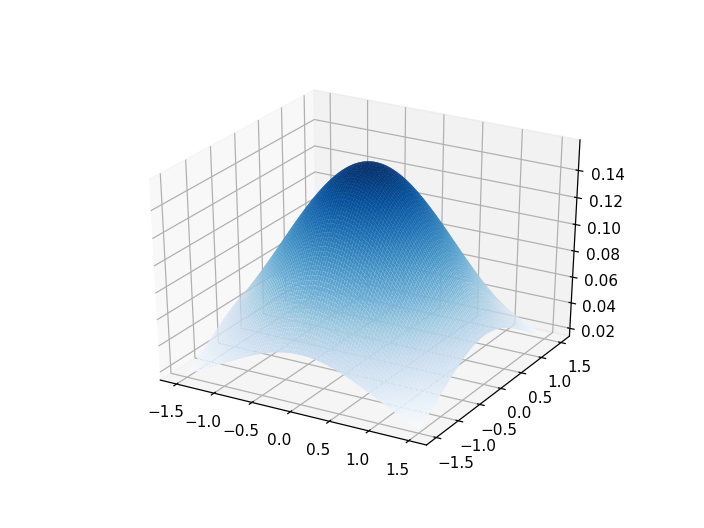

In [5]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


def plot_kernel_3d():
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.linspace(-1.5, 1.5, 100)
    Y = np.linspace(-1.5, 1.5, 100)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros_like(X)
    Z[X**2 + Y**2 < 1] = 1/2

    Z = np.exp(-(X**2 + Y**2) / 2) / (2 * np.pi)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R * 4)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues,
                           linewidth=0, antialiased=True, alpha=None, rstride=1, cstride=1)

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])

    plt.show()

plot_kernel_3d()

<IPython.core.display.Javascript object>


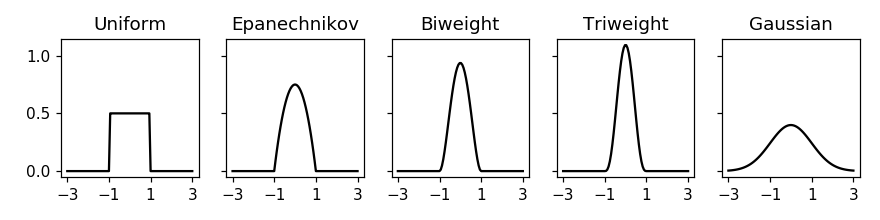

In [6]:
def uniform(u):
    return 1/2 * (np.abs(u) < 1)
def epanechnikov(u):
    return 3/4 * (1 - u**2) * (np.abs(u) < 1)
def gaussian(u):
    return np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)
def biweight(u):
    return 15/16 * (1 - u**2)**2 * (np.abs(u) < 1)
def triweight(u):
    return 35/32 * (1 - u**2)**3 * (np.abs(u) < 1)




def plot_kernels(kernels=[
    uniform,
    epanechnikov,
    biweight,
    triweight,
    gaussian,
], names=[
    'Uniform',
    'Epanechnikov',
    'Biweight',
    'Triweight',
    'Gaussian',
]):
    x = np.linspace(-3, 3, 100)
    ys = [k(x) for k in kernels]

    fig, axes = plt.subplots(ncols=len(ys), figsize=(8, 2), sharey=True)
    for (ax, y, name) in zip(axes, ys, names):
        ax.plot(x, y, 'k', label=name)
        ax.set_title(name)
        ax.set_xticks([-3, -1, 1, 3])


    fig.tight_layout()
    plt.show()

plot_kernels()
plt.savefig(FIG_PATH + '/kde-popular-kernels.png')

In [7]:
from scipy.stats.distributions import norm

<IPython.core.display.Javascript object>


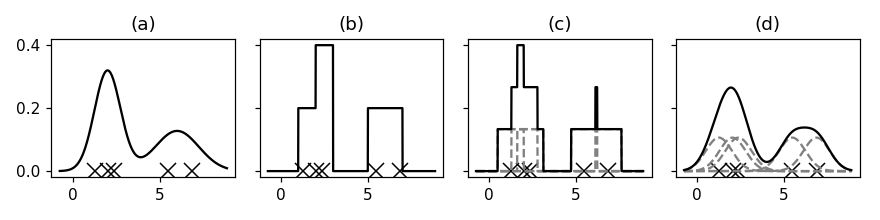

In [8]:
def plot_kernel_density_estimate(*, seed=None):
    np.random.seed(seed)
    
    params = [(2, 0.75, 3), (6, 1.25, 2)]
    data = np.hstack([norm(loc, scale).rvs(size) for (loc, scale, size) in params])

    n = data.shape[0]
    x = np.linspace(data.min() - 2, data.max() + 2, 1000)

    fig, axes = plt.subplots(ncols=4, figsize=(8, 2), subplot_kw=dict(aspect='auto'), sharey=True, sharex=True)
    
    
    hist = np.zeros_like(x)
    for x_i in data:
        j = int(np.floor(x_i))
        mask = (j <= x) & (x < j + 1)
        hist[mask] += 1 # hist[mask] + 1
    hist = hist / data.shape[0]
    
    for ax in axes:
        ax.plot(data, np.zeros_like(data), 'kx', ms=10)

    axes[0].plot(x, sum([norm(loc, scale).pdf(x) * (size/n) for (loc, scale, size) in params]), 'k-')
    axes[0].set_title('(a)')
    
    axes[1].plot(x, hist, 'k-')
    axes[1].set_title('(b)')


    h = 0.75
    for i, k, title in zip([2, 3], [uniform, gaussian], ['(c)', '(d)']):
        for x_i in data:
            axes[i].plot(x, k((x-x_i)/h) / (n*h), '--', color='grey')
        kde = np.sum(np.vstack([k((x-x_i)/h) / (n*h) for x_i in data]), axis=0)
        axes[i].plot(x, kde, 'k-')
        axes[i].set_title(title)

    fig.tight_layout()
    plt.show()

# 0, 3, 4, 6, 9
# for i in [0, 3, 4, 6, 9]:

plot_kernel_density_estimate(seed=4)
plt.savefig(FIG_PATH + '/kde-kernel-density-estimates.png')

In [9]:
def generate_moons_3d(n_samples=200, noise=0.1):
    alpha = 0.05
    t = np.linspace(alpha, 1-alpha, n_samples)
    # t = (t - 0.5) / 4 + 3 * (t - 0.5)**3 + 1/2
    t = np.arccos(1 - 2 * t) / np.pi
    x = np.cos(t * np.pi)
    y = np.sin(t * np.pi)
    z = np.zeros(n_samples)
    i = 1 - np.linspace(-1, 1, n_samples) ** 2

    X = np.vstack([
        np.vstack([x, y, z]).T,
        np.vstack([x + 4/3, -y, z]).T,
        np.vstack([z - 1/3, -y, x]).T
    ])
    y = np.hstack([
        0 * np.ones(n_samples),
        1 * np.ones(n_samples),
        2 * np.ones(n_samples)
    ])
    scale = np.hstack([i] * 3)
    scale = np.vstack([scale] * 3).T

    if noise is not None:
        X += scale * np.random.normal(scale=0.1, size=X.shape)
    
    return X, y

<IPython.core.display.Javascript object>


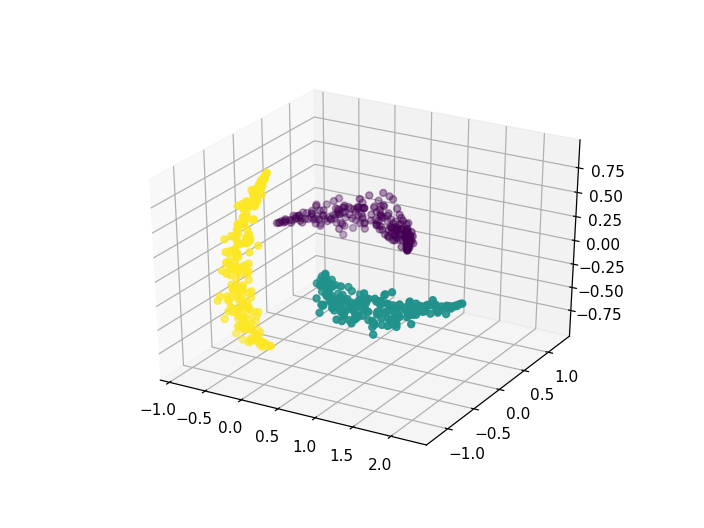

In [10]:
X, y = generate_moons_3d()

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show()

In [11]:
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift


#bandwidth = estimate_bandwidth(X)
ms = MeanShift(0.5)
y_pred = ms.fit_predict(X)
y_pred.max()

2

<IPython.core.display.Javascript object>


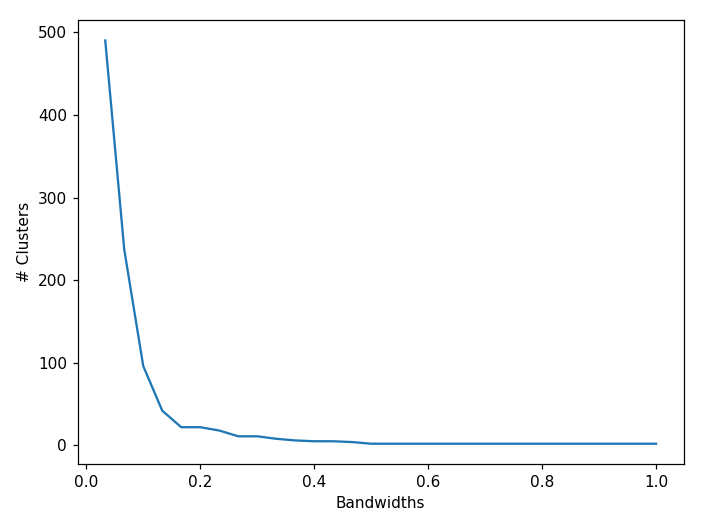

In [12]:
def plot_bandwidth_profile(X, n_bandwidths=30):
    bandwidths = np.linspace(1 / n_bandwidths, 1, n_bandwidths)

    Ks = np.array([MeanShift(bandwidth).fit_predict(X).max() for bandwidth in bandwidths])

    fig, ax = plt.subplots()
    ax.plot(bandwidths, Ks)
    
    ax.set_xlabel('Bandwidths')
    ax.set_ylabel('# Clusters')
    # ax.set_yscale("log", nonposy='clip')

    fig.tight_layout()    
    return fig, ax

fig, ax = plot_bandwidth_profile(X)
plt.show()

<IPython.core.display.Javascript object>


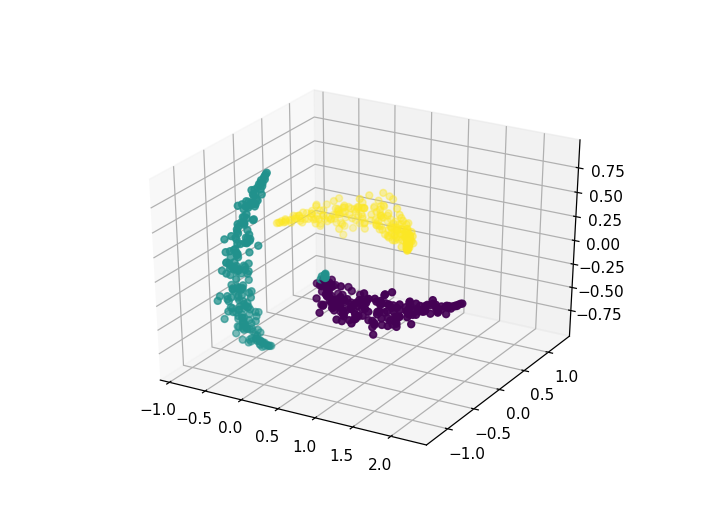

In [13]:
y_pred = MeanShift(0.6).fit_predict(X)


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred)
plt.show()

In [13]:
# bandwidths[Ks <= 2]

<IPython.core.display.Javascript object>


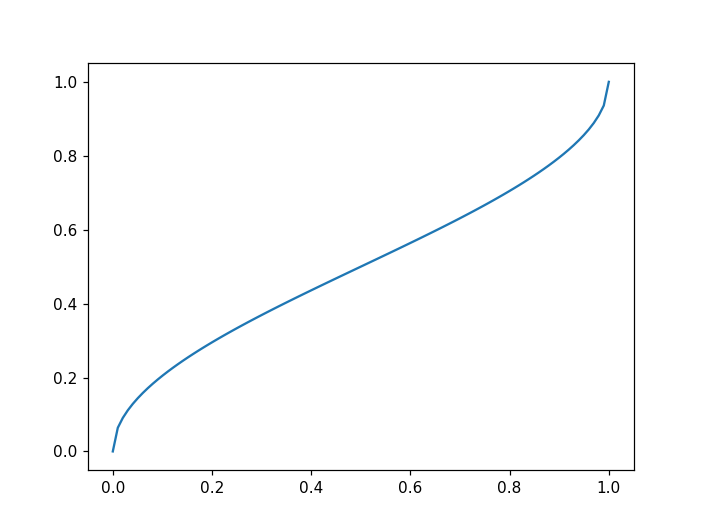

In [14]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, np.arccos(1 - 2 * x) / np.pi)
plt.show()

<IPython.core.display.Javascript object>


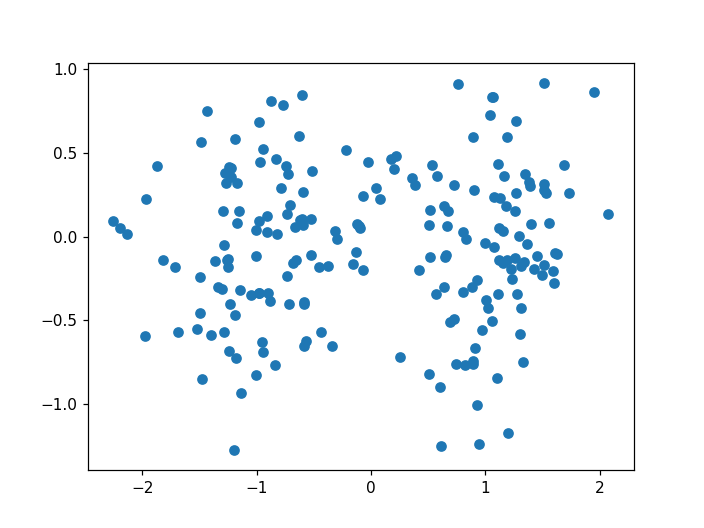

In [15]:
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity

X, y = make_blobs(n_samples=200, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=[0.5, 0.5])


fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])

plt.show()

In [17]:
def kde(X, Z, kernel):
    n, d = X.shape
    res = np.zeros(Z.shape[0])
    for i in range(Z.shape[0]):
        x = Z[i]
        w = np.array([kernel(np.sum((x_i - x)**2)) for x_i in X])
        res[i] = w.sum()
    return res

#def m(X, x, kernel, h=1):
#    n, d = X.shape
#    w = np.array([kernel(np.sum((x_i - x)**2)/h) for x_i in X])
#    return w @ X / w.sum()


def m(X, x, h=1):
    norm = np.sum((X - x)**2, axis=1) / h
    w = 0.5 * (norm < h)
    # w = (1 - norm) / h * (norm < 1)
    w = gaussian(norm)
    return w @ X_train / w.sum()

# kde(X_train, XX, gaussian)

x_start = X_train[0] #np.array([2, -1])
x = x_start
its = [x_start]
h = 0.5
for _ in range(50):
    x_new = m(X_train, x, h)
    its.append(x)
    if np.sum((x_new - x)**2) < 1e-5:
        break
    else:
        x = x_new

its = np.array(its)

In [ ]:
m(np.vstack([1, 2, 6, 7]), np.array([1]))

In [ ]:
# np.mean(X_train[np.sum((X_train - X_train[0])**2, axis=1) < 1], axis=0)
w = 0.5 * (np.sum((X_train - X_train[0])**2, axis=1) < 1)
w @ X_train / w.sum()

<IPython.core.display.Javascript object>


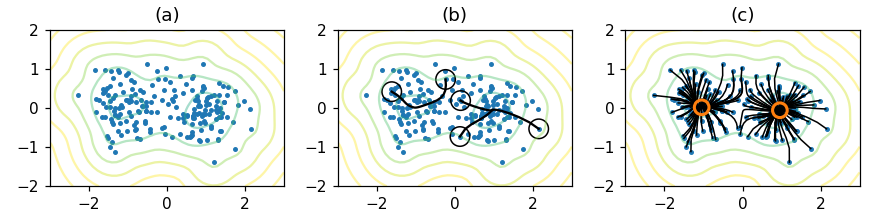

In [113]:
from matplotlib.colors import LogNorm
from sklearn import mixture
from matplotlib.patches import Circle


np.random.seed(0)

X_train, y_true = make_blobs(n_samples=200, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=[0.5, 0.5])

h = 0.25 #0.25
clf = KernelDensity(h)
clf.fit(X_train)

x = np.linspace(-3., 3.)
y = np.linspace(-2., 2.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)


fig, axes = plt.subplots(ncols=3, figsize=(8, 2))
for ax in axes:
    ax.scatter(X_train[:, 0], X_train[:, 1], 5)
    ax.contour(X, Y, Z, norm=LogNorm(vmin=1e-1, vmax=10),
                 levels=np.logspace(0, 3, 15), alpha=0.4)


def get_its(x_start):
    x = x_start
    its = [x_start]
    for _ in range(50):
        x_new = m(X_train, x, h)
        its.append(x)
        if np.sum((x_new - x)**2) < 1e-5:
            break
        else:
            x = x_new

    return np.array(its)


idx = [14, 15, 0, 3, 9]
for x_start in [X_train[i] for i in idx]:
    its = get_its(x_start)
    axes[1].plot(its[:,0], its[:,1], 'k-')
    axes[1].add_patch(Circle(its[0], h, fill=False))

for x_start in [X_train[i] for i in [0, 2]]:
    its = get_its(x_start)
    axes[2].add_patch(Circle(its[-1], h * 0.75, fill=False, color='C1', zorder=10, linewidth=2))

for x_start in X_train:
    its = get_its(x_start)
    axes[2].plot(its[:,0], its[:,1], 'k-', linewidth=1)




for ax, name in zip(axes, ["(a)", "(b)", "(c)"]):
    ax.set_title(name)
    ax.set_aspect('equal', 'box')

fig.tight_layout()
plt.show()

plt.savefig(f"{FIG_PATH}/mean-shift-trajectories.png")

In [104]:
its[-1, 1]

-0.05445559608147265